In [1]:
pwd

'/mmfs1/data/pijarj/BC-ORG-Data/Code'

In [2]:
import pandas as pd
import os
import shutil
import numpy as np
from tqdm import tqdm # pretty pretty
import ants

import nibabel as nib

In [3]:
df = pd.read_csv('../Data/general_csv.csv') #grab master list
df['is_nii_gz'] = [file.endswith('.nii.gz') for file in df['local_paths'].values]
df = df[df['is_nii_gz']]
print(df.shape)
df.head(2)

(3832, 76)


,Unnamed: 0,collection_id,image03_id,dataset_id,subjectkey,src_subject_id,interview_age,sex,comments_misc,image_file,...,visit,slice_timing,bvek_bval_files,deviceserialnumber,procdate,visnum,manifest,collection_title,local_paths,is_nii_gz
0,1,2075,367948,9786,NDARAV510ZB5,1108,107,M,NaN,s3://NDAR_Central_1/submission_10916/TNAD-x-21...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mapping Thalamocortical Networks Across Develo...,./image03/TNAD-x-212988-x-212988-x-501-d0203.n...,True
1,2,2075,367949,9786,NDARCZ285AMD,1147,218,F,NaN,s3://NDAR_Central_1/submission_10916/TNAD-x-21...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mapping Thalamocortical Networks Across Develo...,./image03/TNAD-x-214064-x-214064-x-501-d0203.n...,True


In [4]:
def safe_mkdir(path):
    if not os.path.exists(path):
        os.mkdir(path)
    else:
        pass

In [47]:
def write_json(data,filepath):
    import json
    #data = json.dumps(data)
    with open(filepath, 'w') as outfile:
        json.dump(data, outfile)

In [5]:
study_name = 'Mapping Thalamocortical Networks Across Development in ASD'
study_df = df[df['collection_title']==study_name] # Slice 
study_df.to_csv('../Data/DS2075.csv')
print(study_df.shape)
study_df.head(2)

(783, 76)


,Unnamed: 0,collection_id,image03_id,dataset_id,subjectkey,src_subject_id,interview_age,sex,comments_misc,image_file,...,visit,slice_timing,bvek_bval_files,deviceserialnumber,procdate,visnum,manifest,collection_title,local_paths,is_nii_gz
0,1,2075,367948,9786,NDARAV510ZB5,1108,107,M,NaN,s3://NDAR_Central_1/submission_10916/TNAD-x-21...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mapping Thalamocortical Networks Across Develo...,./image03/TNAD-x-212988-x-212988-x-501-d0203.n...,True
1,2,2075,367949,9786,NDARCZ285AMD,1147,218,F,NaN,s3://NDAR_Central_1/submission_10916/TNAD-x-21...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mapping Thalamocortical Networks Across Develo...,./image03/TNAD-x-214064-x-214064-x-501-d0203.n...,True


In [6]:
study_subjects = np.unique(study_df['subjectkey'].values)
nsubjects = len(study_subjects)
#print(nsubjects)

In [7]:
#nsubjects = len(study_df)
collection_id = study_df['collection_id'].values[0]
collection_id

2075

In [8]:
ndar_root = '../../ndar_fmri/' # What to take scans 
bids_root = '../../' # Where to put scans

In [9]:
def check_has_anat_and_epi(sub):
    #sub = study_subjects[s]
    sub_df = study_df.iloc[study_df['subjectkey'].values==sub]
    fmri_idx = sub_df['image_description'].values=='fMRI'
    anat_idx = sub_df['image_description'].values=='T1'
    return fmri_idx.sum()>0 and anat_idx.sum()>0

In [10]:
has_anat_and_epi = np.array([check_has_anat_and_epi(s) for s in study_subjects])

In [11]:
use_subjects = study_subjects[has_anat_and_epi]
nsubjects = len(use_subjects)
print(nsubjects)

50


In [35]:
s

0

In [156]:
s = 0
sub = use_subjects[s]
sub_df = study_df.iloc[study_df['subjectkey'].values==sub]
fmri_idx = sub_df['image_description'].values=='fMRI'
anat_idx = sub_df['image_description'].values=='T1'

epi_fn = sub_df.iloc[fmri_idx]['local_paths'].values[0]
anat_fn = sub_df.iloc[anat_idx]['local_paths'].values[0]

epi_path = os.path.join(ndar_root,epi_fn[2::])
anat_path = os.path.join(ndar_root,anat_fn[2::])

#ants.slice_image(ants.image_read(epi_path),axis=3,idx=0).plot_ortho(flat=True)
#ants.image_read(anat_path).plot_ortho(flat=True)

epi_dest = os.path.join(bids_root,f'ds-{collection_id}',f'sub-{s+1:03d}','func',f'sub-{s+1:03d}_task-rest_bold.nii.gz')
anat_dest = os.path.join(bids_root,f'ds-{collection_id}',f'sub-{s+1:03d}','anat',f'sub-{s+1:03d}_T1w.nii.gz')



print('done')

done


In [12]:
# MAKE THE BIDS DIRECTORY
safe_mkdir(os.path.join(bids_root,f'ds-{collection_id}'))
for s in range(1,nsubjects+1):
    safe_mkdir(os.path.join(bids_root,f'ds-{collection_id}',f'sub-{s:03d}'))
    safe_mkdir(os.path.join(bids_root,f'ds-{collection_id}',f'sub-{s:03d}','func'))
    safe_mkdir(os.path.join(bids_root,f'ds-{collection_id}',f'sub-{s:03d}','anat'))

In [ ]:
for s in tqdm(range(0,nsubjects)):
    sub = use_subjects[s]
    sub_df = study_df.iloc[study_df['subjectkey'].values==sub]
    fmri_idx = sub_df['image_description'].values=='fMRI'
    anat_idx = sub_df['image_description'].values=='T1'

    epi_fn = sub_df.iloc[fmri_idx]['local_paths'].values[0]
    anat_fn = sub_df.iloc[anat_idx]['local_paths'].values[0]

    epi_path = os.path.join(ndar_root,epi_fn[2::])
    anat_path = os.path.join(ndar_root,anat_fn[2::])

    #ants.slice_image(ants.image_read(epi_path),axis=3,idx=0).plot_ortho(flat=True)
    #ants.image_read(anat_path).plot_ortho(flat=True)

    epi_dest = os.path.join(bids_root,f'ds-{collection_id}',f'sub-{s+1:03d}','func',f'sub-{s+1:03d}_task-rest_bold.nii.gz')
    anat_dest = os.path.join(bids_root,f'ds-{collection_id}',f'sub-{s+1:03d}','anat',f'sub-{s+1:03d}_T1w.nii.gz')

    ## This really should've worked... smh
    #shutil.copyfile(src=anat_path, dst=anat_dest, follow_symlinks=True)
    #shutil.copyfile(src=epi_path, dst=epi_dest, follow_symlinks=True)


    # World Famous Aglinskas hax
    t1 = ants.image_read(anat_path) 
    bold = ants.image_read(epi_path)

    t1.to_filename(anat_dest) # [ERR] _T1w.nii[.gz] files must have exactly three dimensions.  (code: 95 - T1W_FILE_WITH_TOO_MANY_DIMENSIONS)
    bold.to_filename(epi_dest)

    bold_json = {"RepetitionTime" : bold.spacing[-1],
                "TaskName" : 'rest'}

    # Write BOLD .json
    write_json(bold_json,epi_dest.replace('.nii.gz','.json')) ### [ERR] You have to define 'RepetitionTime' for this file. (code: 10 - REPETITION_TIME_MUST_DEFINE)

    # Holy shit it's still putting up a fight...  ## [ERR] Repetition time was not defined in seconds, milliseconds or microseconds in the scan's header. (code: 11 - REPETITION_TIME_UNITS)
    im = nib.load(epi_dest)
    header = im.header.copy()
    header.set_xyzt_units(xyz='mm', t='sec')
    nib.nifti1.Nifti1Image(im.get_fdata(), None, header=header).to_filename(epi_dest)
    assert nib.load(epi_dest).header.get_xyzt_units()==('mm', 'sec'),'timing missing from header'


 78%|███████▊  | 39/50 [10:33<02:56, 16.09s/it]

In [33]:
## write the dataset_description.json
import json
##data = {'Name' : study_df['collection_title'].values[0] ,
       ##'BIDSVersion' : '20.2.0'}
data = {
    "Name" : study_df["collection_title"].values[0] ,
    "RepetitionTime": 2.0,
    "SliceTiming" : 2.0 ,
    "TaskName" : "taskrest" ,
    "BIDSVersion" : "20.2.0"
    #'RepetitionTime': study_df['mri_repetition_time_pd'].values[0]
    }
json_string = json.dumps(data)
print(json_string)

# Directly from dictionary
with open(os.path.join(bids_root,f'ds-{collection_id}','dataset_description.json'), 'w') as outfile:
    json.dump(json_string, outfile)

{"Name": "Mapping Thalamocortical Networks Across Development in ASD", "RepetitionTime": 2.0, "SliceTiming": 2.0, "TaskName": "taskrest", "BIDSVersion": "20.2.0"}


In [34]:
json_string

'{"Name": "Mapping Thalamocortical Networks Across Development in ASD", "RepetitionTime": 2.0, "SliceTiming": 2.0, "TaskName": "taskrest", "BIDSVersion": "20.2.0"}'

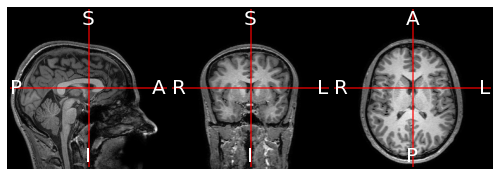

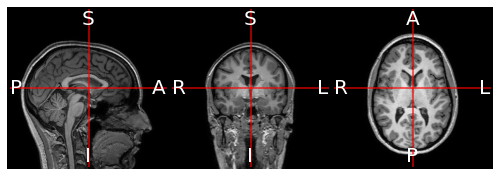

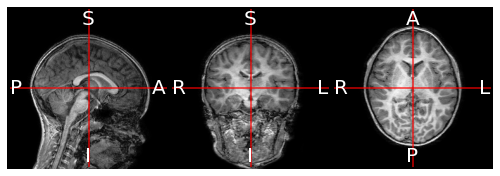

In [43]:
ants.image_read(os.path.join('~/ds-2075/sub-034/anat/sub-034_T1w.nii.gz')).plot_ortho(flat=True)
ants.image_read(os.path.join('~/ds-2075/sub-001/anat/sub-001_T1w.nii.gz')).plot_ortho(flat=True)
ants.image_read(os.path.join('~/ds-2075/sub-050/anat/sub-050_T1w.nii.gz')).plot_ortho(flat=True)